# Multi Omic Data Intergration

In [2]:
import anndata as ad
import networkx as nx
import scanpy as sc
import scglue
from matplotlib import rcParams
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)
import warnings 
warnings.filterwarnings("ignore")

/home/abbas/anaconda3/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## Data

### RNA data

The data includes a list of 9,190 cells with details about each cell's type and the sequencing method used. For each cell, it provides a unique identifier and its classification into specific cell types. Additionally, there's a list of 28,930 genes, showing which genes were measured. The rna data also contains gene expression data for 9,190 cells across 28,930 genes. It holds a large number of measurements, with 8,633,857 recorded values representing the gene activity levels in these cells.

In [6]:
rna = ad.read_h5ad("Chen-2019-RNA.h5ad")

In [7]:
import pandas as pd
from IPython.display import display, HTML

# Create HTML tables from the DataFrames
obs_html = rna.obs.head().to_html()
var_html = rna.var.head().to_html()

# Get sizes
obs_size = rna.obs.shape
var_size = rna.var.shape
X_size = pd.DataFrame(rna.X.toarray()).shape

# Convert rna.X to a DataFrame and limit to 5 rows by 10 columns
X_df = pd.DataFrame(rna.X.toarray()).iloc[:5, :10]  # Select 5 rows and 10 columns
X_html = X_df.to_html()

# Combine the tables side by side using HTML
combined_html = f"""
<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; margin-right: 20px;">
        <h3>rna.obs ({obs_size[0]} cells, {obs_size[1]} columns)</h3>
        {obs_html}
    </div>
    <div style="flex: 1; margin-right: 20px;">
        <h3>rna.var ({var_size[0]} genes)</h3>
        {var_html}
    </div>
    <div style="flex: 1;">
        <h3>rna.X ({X_size[0]} rows x {X_size[1]} columns)</h3>
        {X_html}
    </div>
</div>
"""

# Display the combined HTML
display(HTML(combined_html))


In [8]:
rna.obs

,domain,cell_type
cells,,
09L_GTTAGAACAGAT_RNA,scRNA-seq,E6Tle4
09I_CATAGCTCAACG_RNA,scRNA-seq,E2Rasgrf2
09G_TTACAGGCAGGT_RNA,scRNA-seq,InP
09B_CTATGGGCGTGC_RNA,scRNA-seq,E4Il1rapl2
09L_AGTGATTGTTCG_RNA,scRNA-seq,Peri
...,...,...
09E_CCTGCTCGTCAC_RNA,scRNA-seq,Peri
09E_TGAGCACCTCCT_RNA,scRNA-seq,E5Parm1
09E_CCGGACTCGATC_RNA,scRNA-seq,E3Rorb


### DNA data

The dataset provides information on single-cell chromatin accessibility. It includes details about each cell and the regions of the genome where accessibility was measured. The main data is a matrix showing how accessible these regions are in each cell.

In [10]:
atac = ad.read_h5ad("Chen-2019-ATAC.h5ad")

In [11]:
import anndata as ad
import pandas as pd
from IPython.display import display, HTML

# Load the dataset
atac = ad.read_h5ad("Chen-2019-ATAC.h5ad")

# Extract key components
obs_df = atac.obs
var_df = atac.var
X_df = pd.DataFrame(atac.X.toarray()).iloc[:5, :10]  # Convert to dense and select 5 rows x 10 columns

# Get sizes
obs_size = obs_df.shape
var_size = var_df.shape
X_size = pd.DataFrame(atac.X.toarray()).shape

# Convert to HTML
obs_html = obs_df.head().to_html()
var_html = var_df.head().to_html()
X_html = X_df.to_html()

# Combine the tables side by side using HTML
combined_html = f"""
<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; margin-right: 20px;">
        <h3>atac.obs ({obs_size[0]} cells, {obs_size[1]} columns)</h3>
        {obs_html}
    </div>
    <div style="flex: 1; margin-right: 20px;">
        <h3>atac.var ({var_size[0]} features)</h3>
        {var_html}
    </div>
    <div style="flex: 1;">
        <h3>atac.X ({X_size[0]} rows x {X_size[1]} columns)</h3>
        {X_html}
    </div>
</div>
"""

# Display the combined HTML
display(HTML(combined_html))


In [24]:
rna.layers["counts"] = rna.X.copy()

We are going to identify the top 2000 genes with the highest variability across cells using a method adapted from Seurat. This will help us focus on the most informative genes for further analysis.

In [27]:
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")

We will perform a series of preprocessing steps on the data:


1. Normalize the data to ensure that the total gene counts are comparable across cells.


In [34]:
sc.pp.normalize_total(rna)


2. Log-transform the data to stabilize variance and make it more normally distributed.


In [37]:
sc.pp.log1p(rna)


3. Scale the data to standardize the values, making them mean-centered and scaled to unit variance.


In [40]:
sc.pp.scale(rna)


4. Perform Principal Component Analysis (PCA) to reduce dimensionality, capturing the most significant variations in the data using up to 100 principal components.

In [42]:
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

We will compute nearest neighbors using cosine distance and apply UMAP to reduce the data to 2D. The UMAP plot will be colored by cell type to visualize the distribution of different cell types.

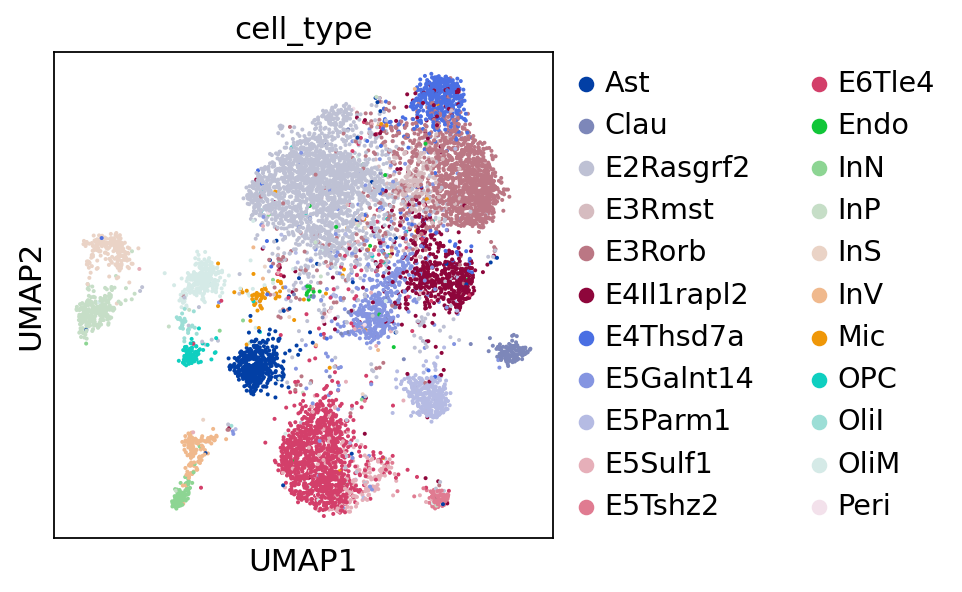

In [46]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.pl.umap(rna, color="cell_type")

The UMAP plot will display cells in a two-dimensional space, with each point representing a cell. Cells of different types will be colored differently, allowing you to see how distinct cell types cluster together or spread out in the reduced dimensional space. This visualization helps in understanding the relationships and separation between various cell types based on their gene expression profiles.

Next step performs dimensionality reduction on the ATAC-seq data using Latent Semantic Indexing (LSI). We will reduce the data to 100 components, iterating the process 15 times to capture the most significant features of the chromatin accessibility data.

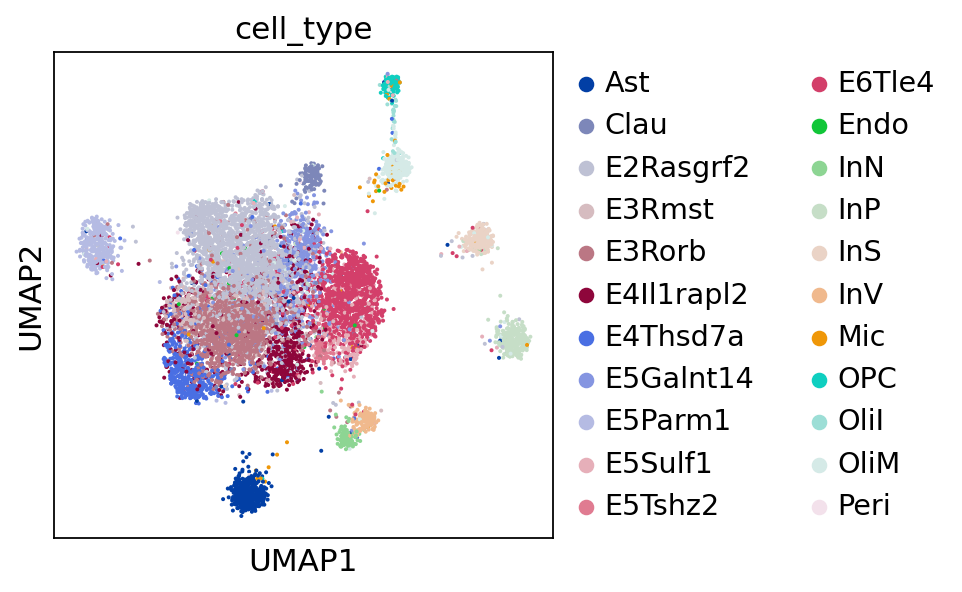

In [51]:
scglue.data.lsi(atac, n_components=100, n_iter=15)
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)
sc.pl.umap(atac, color="cell_type")

We are going to annotate the genes in the RNA-seq data using information from a GTF file (Gencode vM25 annotation). This process will match gene names to their corresponding genomic coordinates (chromosome, start, and end positions). After annotation, we can view the first few entries to check the chromosome locations and positions of the annotated genes.

In [54]:
scglue.data.get_gene_annotation(
    rna, gtf="gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
genes,,,
0610005C13Rik,chr7,45567793,45575327
0610009B22Rik,chr11,51685385,51688874
0610009E02Rik,chr2,26445695,26459390
0610009L18Rik,chr11,120348677,120351190
0610010F05Rik,chr11,23564960,23633639


We are going to extract and organize genomic information from the ATAC-seq data. By splitting the region names into separate components, we will identify the chromosome, start, and end positions for each peak

In [57]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac.var.head()

,chrom,chromStart,chromEnd
peaks,,,
chr1:3005833-3005982,chr1,3005833,3005982
chr1:3094772-3095489,chr1,3094772,3095489
chr1:3119556-3120739,chr1,3119556,3120739
chr1:3121334-3121696,chr1,3121334,3121696
chr1:3134637-3135032,chr1,3134637,3135032


We are going to create a guidance graph that integrates RNA-seq and ATAC-seq data, using the RNA-seq data to anchor and guide the integration. This graph captures the relationships between gene expression (RNA-seq) and chromatin accessibility (ATAC-seq), helping to align and combine these two datasets for further analysis. After constructing the guidance graph, we can inspect it to understand how the two datasets are connected.

To construct a prior regulatory graph for integrating scRNA-seq and scATAC-seq data, we create nodes representing omics features (genes for RNA-seq and peaks for ATAC-seq) and edges indicating regulatory interactions with attributes for weight (ranging from 0 to 1) and sign (1 for positive, -1 for negative). Each node also includes a self-loop with a weight of 1 and a sign of 1. The graph, constructed using Networkx, should cover all features in the datasets and ensure integrity for successful multi-omics alignment using GLUE.

In [60]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac)

window_graph:   0%|          | 0/28930 [00:00<?, ?it/s]

We will check the integrity and consistency of the guidance graph that was created to integrate the RNA-seq and ATAC-seq datasets. This step ensures that the graph accurately represents the relationships between the two datasets and that there are no discrepancies or issues before proceeding with further analysis.

In [62]:
scglue.graph.check_graph(guidance, [rna, atac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


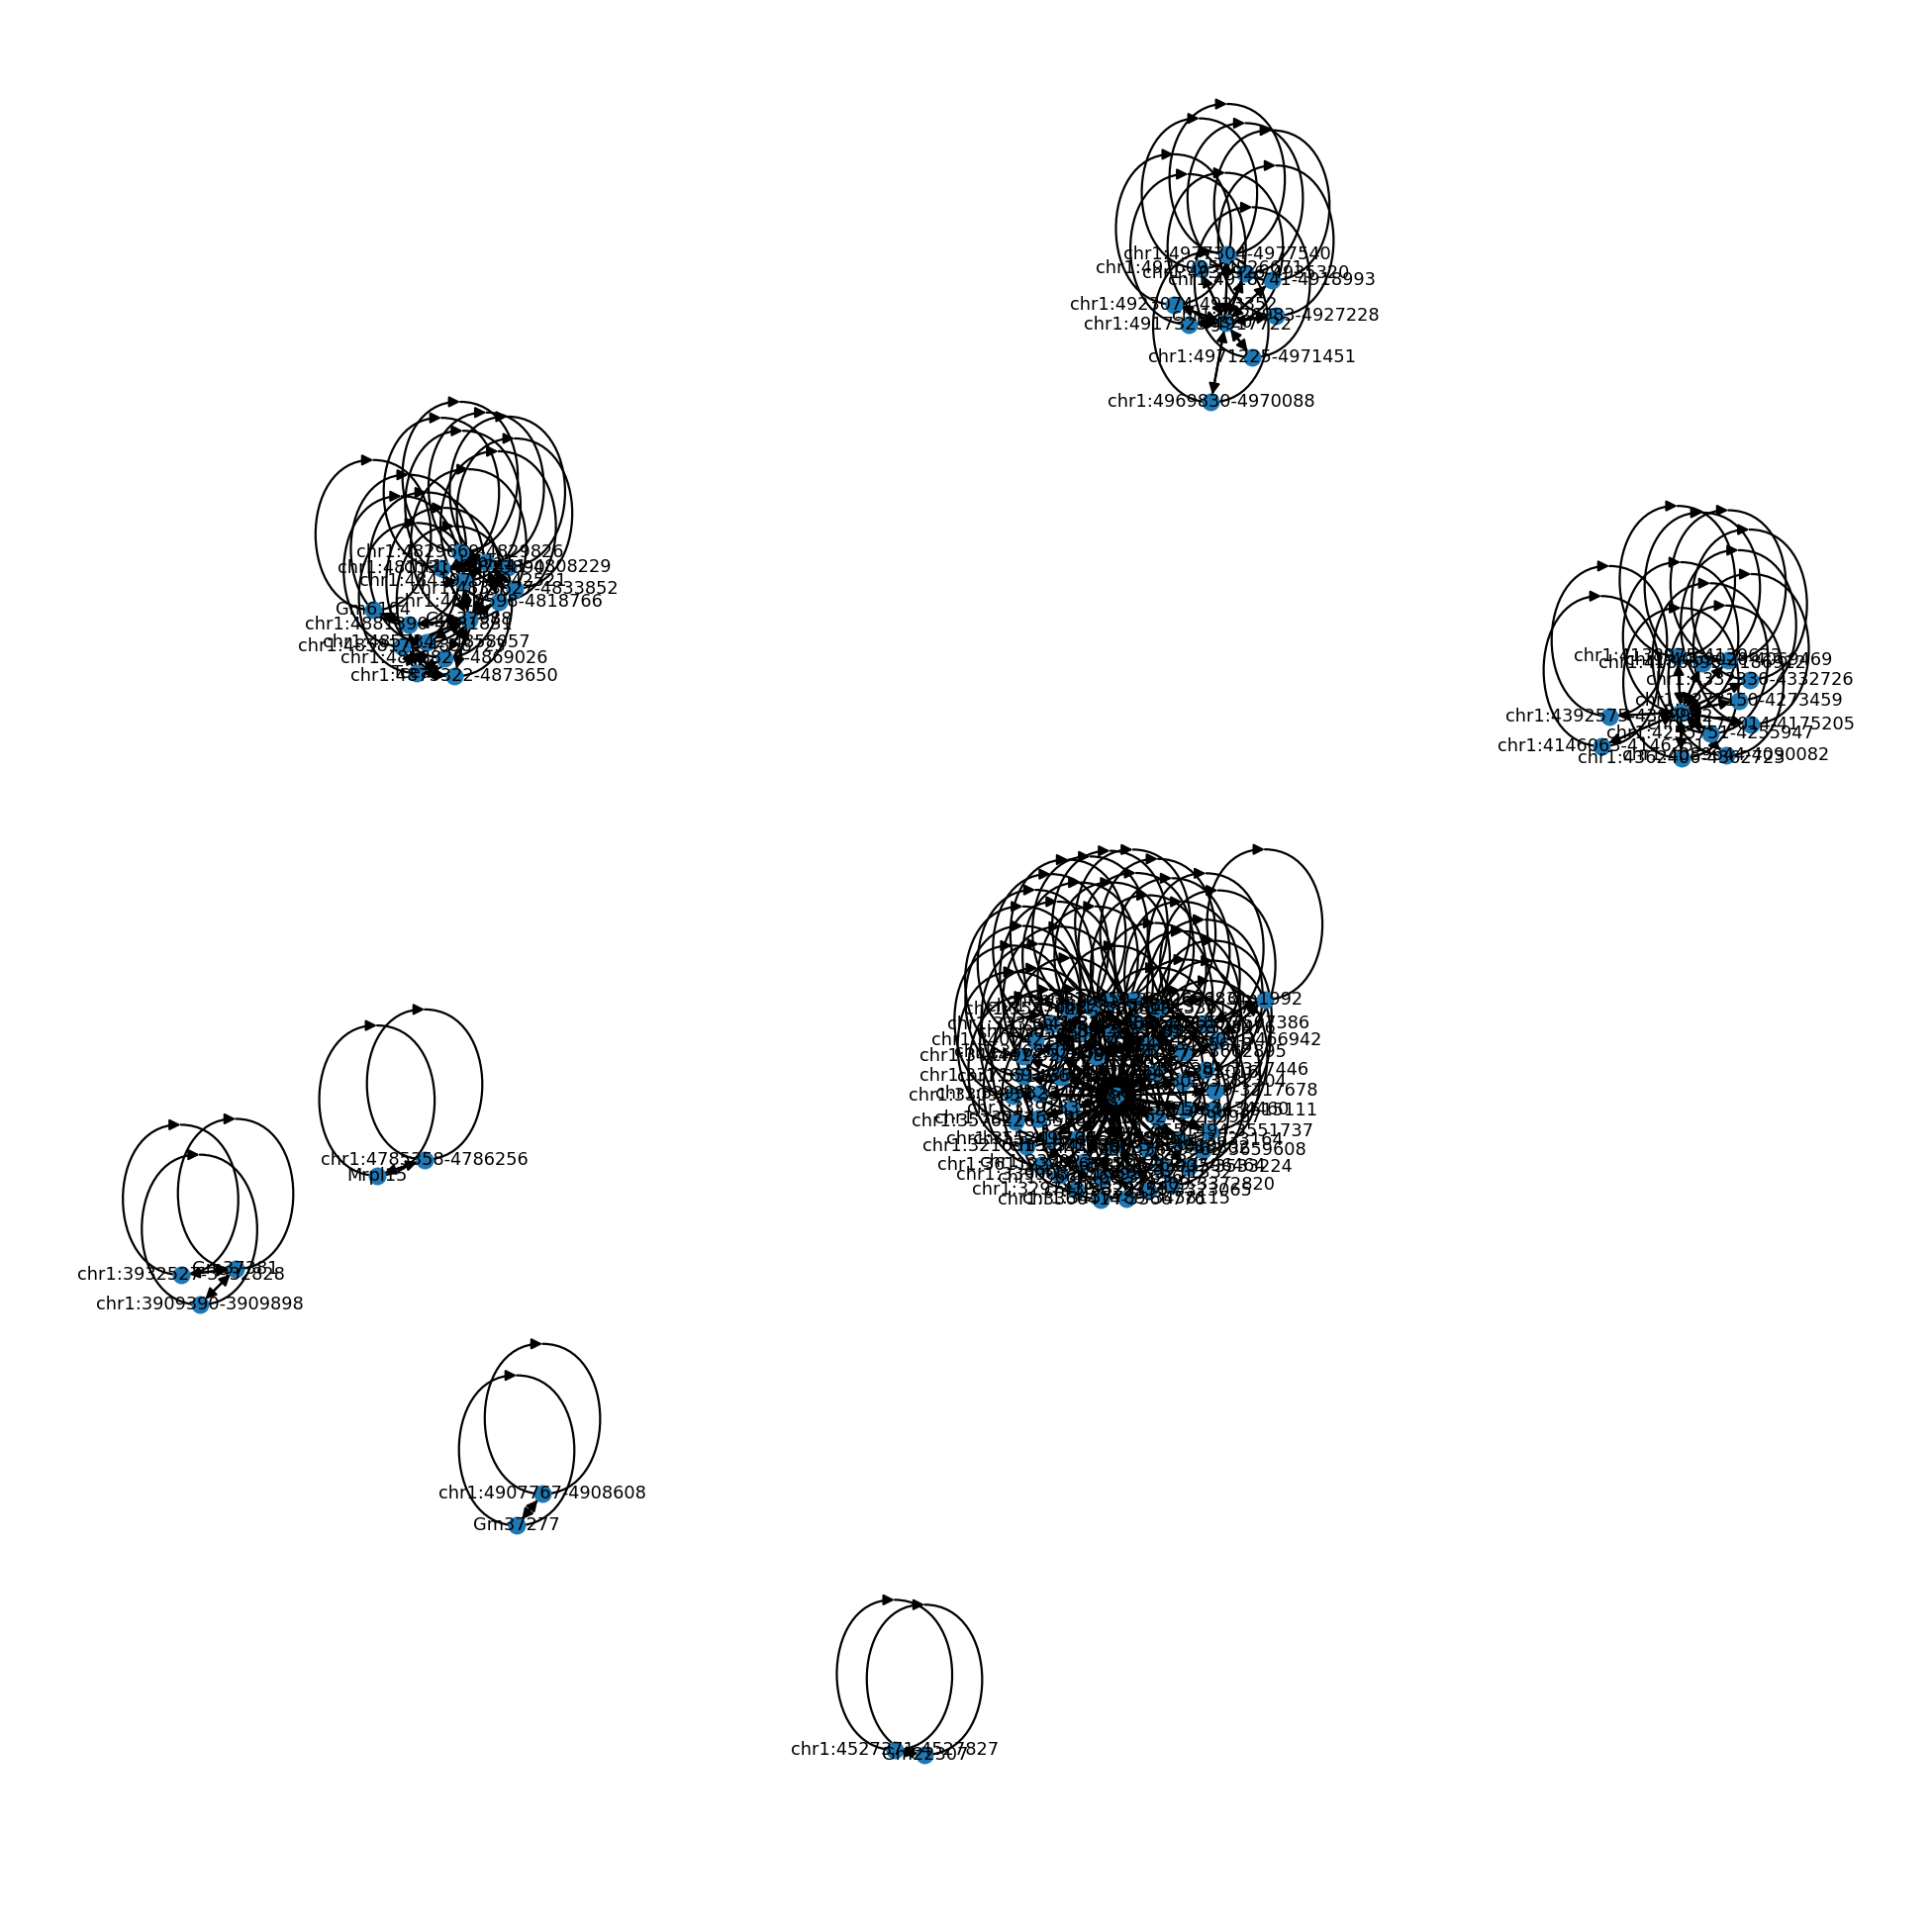

In [78]:
import networkx as nx
import matplotlib.pyplot as plt

# Extract a small subgraph for visualization
subgraph_nodes = list(guidance.nodes)[:100]  # Adjust the number to select more or fewer nodes
subgraph = guidance.subgraph(subgraph_nodes)

# Plot the subgraph
plt.figure(figsize=(12, 12))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.show()


In [80]:
rna.write("rna-pp.h5ad", compression="gzip")
atac.write("atac-pp.h5ad", compression="gzip")
nx.write_graphml(guidance, "guidance.graphml.gz")

## Data preparing for training

In [89]:
from itertools import chain

import anndata as ad
import itertools
import networkx as nx
import pandas as pd
import scanpy as sc
import scglue
import seaborn as sns
from matplotlib import rcParams

We are configuring the dataset to use highly variable genes and raw count data. Additionally, we'll utilize the PCA results for dimensionality reduction, ensuring the data is well-prepared for further analysis.

In [84]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca"
)
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

We are creating a focused subgraph from the guidance graph that includes only the highly variable features from both the gene expression and chromatin accessibility datasets. This subgraph highlights the most informative features, making it more relevant for analysis and visualization.








In [91]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

## Training 

SCGLUE (Single-Cell Graph-Learning Unifying Embedding) integrates unpaired single-cell multi-omics data, such as scRNA-seq and scATAC-seq, into a unified latent space using an encoder-decoder framework. Each dataset's encoder maps its data into a shared latent space, while the decoder reconstructs the original data from these embeddings. The model employs a cost function that combines several key components: reconstruction loss ensures that the embeddings retain critical information from the raw data, modeled using a Negative Binomial distribution for count data; graph consistency loss enforces that the learned embeddings respect the biological relationships encoded in the guidance graph, which captures interactions and connections between features; alignment loss aligns embeddings from different omics types, ensuring that corresponding biological entities are matched across datasets; and regularization terms prevent overfitting and promote desirable properties in the latent space. The guidance graph is used to enhance the model's ability to integrate data by leveraging known biological interactions, thereby improving the coherence and relevance of the learned embeddings. The total loss is a weighted sum of these components, and the model is trained using gradient-based optimization techniques to minimize this loss and achieve optimal integration of multi-omics data.

In [93]:
#glue = scglue.models.fit_SCGLUE(
#    {"rna": rna, "atac": atac}, guidance_hvf,
#    fit_kws={"directory": "glue"}
#)
#glue.save("glue.dill")
glue = scglue.models.load_model("glue.dill")

[INFO] autodevice: Using CPU as computation device.


We are evaluating the consistency of the integrated data by applying a model that assesses how well the integrated features from gene expression and chromatin accessibility datasets align with the guidance subgraph. This process helps to ensure that the integration is accurate and meaningful, focusing on the most informative features.

[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


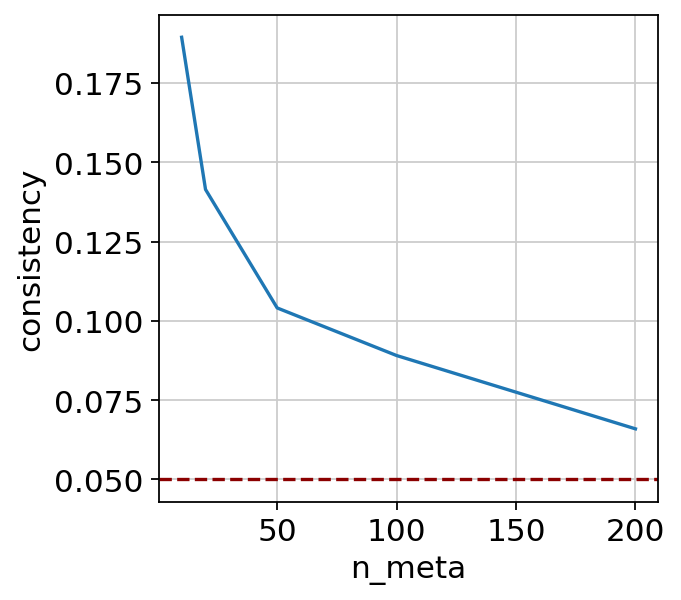

In [98]:
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, guidance_hvf
)
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")

We are encoding the gene expression and chromatin accessibility data into a unified representation using the integration model. This involves applying the model to transform both datasets into a common feature space, which is then stored for further analysis.

In [101]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)
combined = ad.concat([rna, atac])

We are combining the gene expression and chromatin accessibility datasets into a single dataset and then performing a series of analyses. First, we compute the neighborhood relationships using the integrated feature representation. Next, we apply UMAP for dimensionality reduction to visualize the data in a lower-dimensional space. Finally, we plot the UMAP results, coloring by cell type and domain to explore the relationships between the integrated datasets.

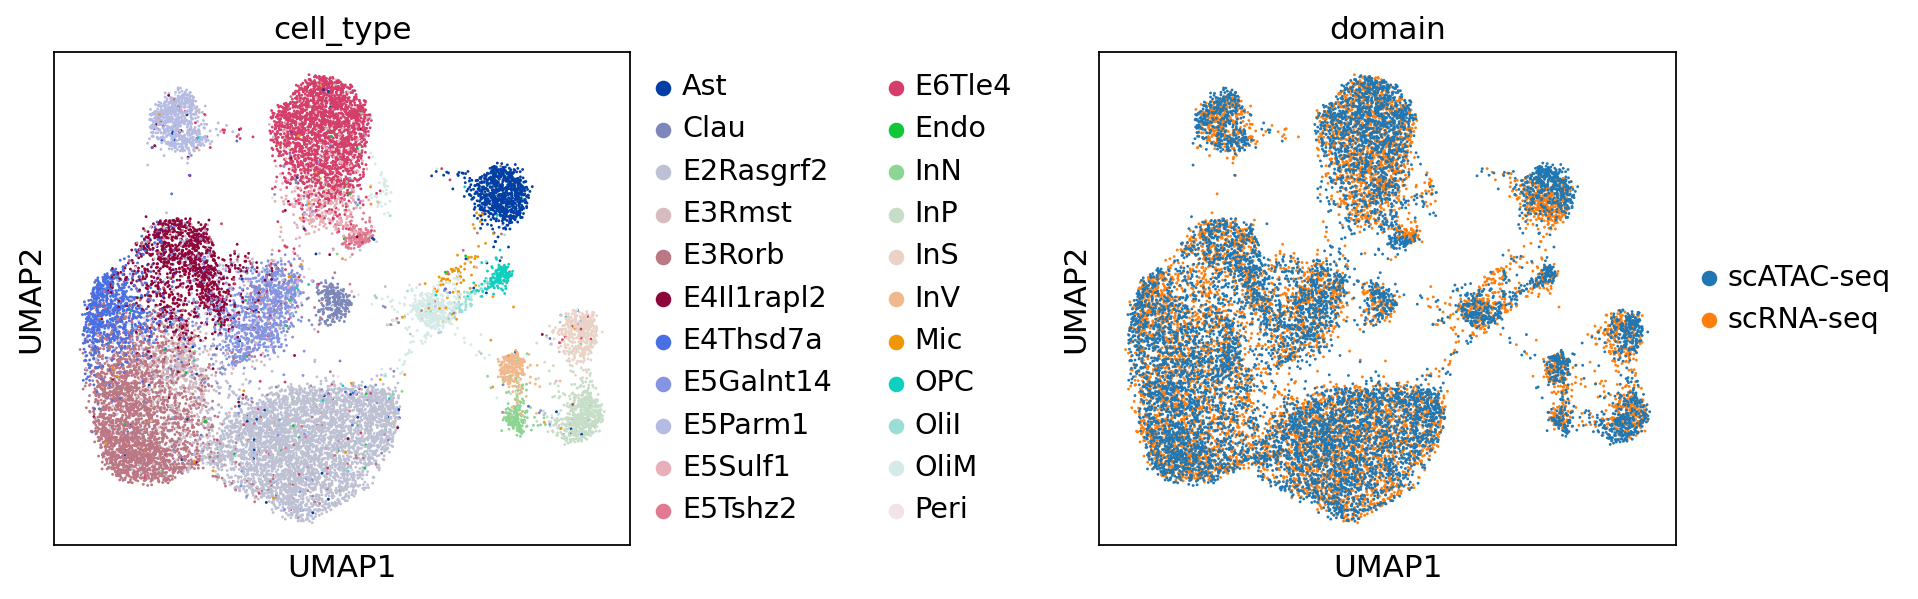

In [103]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
sc.pl.umap(combined, color=["cell_type", "domain"], wspace=0.65)

We are generating embeddings for the features in our guidance graph using the integration model. These embeddings represent each feature in a lower-dimensional space, which we then organize into a dataframe. The initial rows and columns of this dataframe are displayed to provide a preview of the feature representations.

In [116]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
rna.varm["X_glue"] = feature_embeddings.reindex(rna.var_names).to_numpy()
atac.varm["X_glue"] = feature_embeddings.reindex(atac.var_names).to_numpy()
rna.write("rna-emb.h5ad", compression="gzip")
atac.write("atac-emb.h5ad", compression="gzip")
nx.write_graphml(guidance_hvf, "guidance-hvf.graphml.gz")
feature_embeddings.iloc[:5, :5]

,0,1,2,3,4
0610009B22Rik,-0.593604,-0.000246,0.156112,0.000215,0.002296
0610025J13Rik,0.039622,-0.002154,-0.106189,-0.006129,-0.000648
1110002J07Rik,0.501838,-0.001095,-0.113705,-0.009719,-0.002778
1110006O24Rik,-0.241173,-0.006119,0.060274,0.000491,0.001784
1110020A21Rik,0.155424,0.006105,-0.215441,-0.006837,-0.007636


In [117]:
import anndata as ad
import networkx as nx
import numpy as np
import pandas as pd
import scglue
import seaborn as sns
from IPython import display
from matplotlib import rcParams
from networkx.algorithms.bipartite import biadjacency_matrix
from networkx.drawing.nx_agraph import graphviz_layout

## Regulatory Inference 

This involves identifying significant cis-regulatory regions (ATAC peaks) associated with each gene based on the GLUE-inferred feature embeddings. The goal is to link these regulatory regions with gene expression, thus revealing potential regulatory interactions.

In [118]:
rna = ad.read_h5ad("rna-emb.h5ad")
atac = ad.read_h5ad("atac-emb.h5ad")
guidance_hvf = nx.read_graphml("guidance-hvf.graphml.gz")


In the context of integrating scRNA-seq and scATAC-seq data, these two lines of code are used to select highly variable features from each dataset:

In [119]:
rna.var["name"] = rna.var_names
atac.var["name"] = atac.var_names
genes = rna.var.query("highly_variable").index
peaks = atac.var.query("highly_variable").index

We are creating a combined list of all feature names from both the gene expression and chromatin accessibility datasets. Then, we concatenate their respective embeddings into a single array. This allows us to have a unified set of feature representations for subsequent analysis.

In [121]:
features = pd.Index(np.concatenate([rna.var_names, atac.var_names]))
feature_embeddings = np.concatenate([rna.varm["X_glue"], atac.varm["X_glue"]])

We need to extract a "skeleton" graph to refine our regulatory inference by focusing only on specific, relevant interactions. This approach narrows down the search space for potential regulatory pairs, reducing the likelihood of false positives that could arise from random correlations. The skeleton graph serves to limit the potential regulatory pairs to those that are more likely to be biologically relevant.

In [123]:
skeleton = guidance_hvf.edge_subgraph(
    e for e, attr in dict(guidance_hvf.edges).items()
    if attr["type"] == "fwd"
).copy()

We are performing regulatory inference to identify potential regulatory relationships between features using the embeddings and the "skeleton" graph. This process aims to predict regulatory interactions based on the refined connections, with results influenced by a fixed random seed for reproducibility.

In [125]:
reginf = scglue.genomics.regulatory_inference(
    features, feature_embeddings,
    skeleton=skeleton, random_state=0
)

regulatory_inference:   0%|          | 0/25565 [00:00<?, ?it/s]


We are creating a subgraph that includes only the regulatory interactions with a significance value below 0.05. This subgraph, gene2peak, highlights the most statistically significant regulatory relationships between genes and peaks.

In [129]:
gene2peak = reginf.edge_subgraph(
    e for e, attr in dict(reginf.edges).items()
    if attr["qval"] < 0.05
)

## Regulatory Region Visualization

We are exporting the peak locations from the chromatin accessibility dataset to a BED file format, which is a standard format for genomic data. Additionally, we write the regulatory links between genes and peaks to a separate file, including attributes like the score, to capture the significant interactions identified in the previous step.

In [136]:
scglue.genomics.Bed(atac.var).write_bed("peaks.bed", ncols=3)
scglue.genomics.write_links(
    gene2peak,
    scglue.genomics.Bed(rna.var).strand_specific_start_site(),
    scglue.genomics.Bed(atac.var),
    "gene2peak.links", keep_attrs=["score"]
)

We are creating a configuration file named tracks.ini for visualizing genomic data. This file specifies settings for displaying regulatory interactions, chromatin accessibility peaks, and gene annotations. It includes details such as file paths, visualization styles, and display preferences to effectively present the data in a genome browser.

In [137]:
%%writefile tracks.ini

[Score]
file = gene2peak.links
title = Score
height = 2
color = YlGnBu
compact_arcs_level = 2
use_middle = True
file_type = links

[ATAC]
file = peaks.bed
title = ATAC
display = collapsed
border_color = none
labels = False
file_type = bed

[Genes]
file = gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz
title = Genes
prefered_name = gene_name
height = 4
merge_transcripts = True
labels = True
max_labels = 100
all_labels_inside = True
style = UCSC
file_type = gtf

[x-axis]
fontsize = 12

Overwriting tracks.ini


We are setting up a genomic visualization for a specific gene, Gad2. First, we determine the chromosome and extend the region around the gene by twice its length to provide a broader view. Then, we use pyGenomeTracks with the configuration specified in tracks.ini to generate an image of this region and display it.

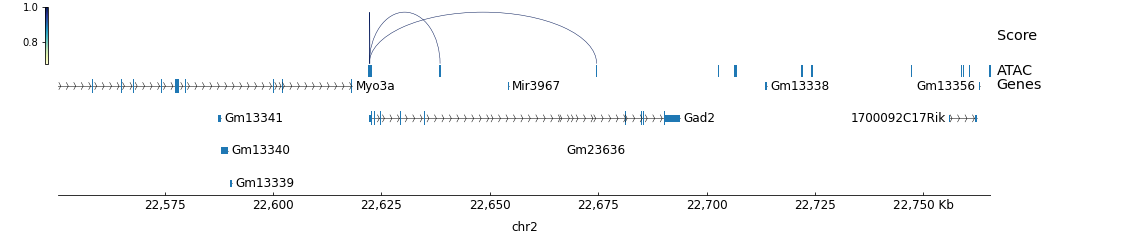

In [143]:
loc = rna.var.loc["Gad2"]
chrom = loc["chrom"]
chromLen = loc["chromEnd"] - loc["chromStart"]
chromStart = loc["chromStart"] - chromLen
chromEnd = loc["chromEnd"] + chromLen
!pyGenomeTracks --tracks tracks.ini \
    --region {chrom}:{chromStart}-{chromEnd} \
    --outFileName tracks.png 2> /dev/null
display.Image("tracks.png")

## TF Gene Regulatory Netwrok

We are loading a BED file containing motif information from the JASPAR 2022 database. This file includes data on genomic motifs, which are patterns in DNA that are recognized by specific transcription factors. 

In [147]:
motif_bed = scglue.genomics.read_bed("JASPAR2022-mm10.bed")
motif_bed.head()

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,GL456210.1,159,171,Zbtb6,.,.,.,.,.,.,.,.
1,GL456210.1,242,253,Osr2,.,.,.,.,.,.,.,.
2,GL456210.1,266,278,Pou2f3,.,.,.,.,.,.,.,.
3,GL456210.1,505,517,Eomes,.,.,.,.,.,.,.,.
4,GL456210.1,507,516,Tbr1,.,.,.,.,.,.,.,.


In [149]:
tfs = pd.Index(motif_bed["name"]).intersection(rna.var_names)
tfs.size

532

In [150]:
rna[:, np.union1d(genes, tfs)].write_loom("rna.loom")
np.savetxt("tfs.txt", tfs, fmt="%s")

The loom file will lack these fields:
{'X_pca', 'X_glue', 'X_umap', 'PCs'}
Use write_obsm_varm=True to export multi-dimensional annotations


In [151]:
!pyscenic grn rna.loom tfs.txt \
    -o draft_grn.csv --seed 0 --num_workers 20 \
    --cell_id_attribute cells --gene_attribute genes


2024-08-21 23:31:21,751 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-08-21 23:31:22,392 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
preparing dask client
parsing input
creating dask graph
not shutting down client, client was created externally
finished
2024-08-21 23:32:16,363 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/abbas/anaconda3/lib/python3.12/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/abbas/anaconda3/lib/python3.12/site-packages/distributed/worker.py", line 1250, in heartbeat
    response = await retry_operation(
               ^^^^^^

In [211]:
## TF Regulatory Ranking 

We are creating a graph that connects chromatin accessibility peaks to transcription factor (TF) motifs. First, we generate a window-based graph where peaks are linked to nearby motifs. Then, we filter this graph to include only the edges where the motifs are known transcription factors, resulting in a subgraph that highlights relevant regulatory interactions between peaks and TFs.

In [154]:
peak_bed = scglue.genomics.Bed(atac.var.loc[peaks])
peak2tf = scglue.genomics.window_graph(peak_bed, motif_bed, 0, right_sorted=True)
peak2tf = peak2tf.edge_subgraph(e for e in peak2tf.edges if e[1] in tfs)

window_graph:   0%|          | 0/25488 [00:00<?, ?it/s]

We are ranking cis-regulatory interactions between genes and transcription factors based on their connections through chromatin accessibility peaks. This process evaluates the significance of each gene-TF pair by considering their linkage through these peaks and the region sizes. The result is a ranked table showing the top interactions, with each entry reflecting the strength of the regulatory association.

In [156]:
gene2tf_rank_glue = scglue.genomics.cis_regulatory_ranking(
    gene2peak, peak2tf, genes, peaks, tfs,
    region_lens=atac.var.loc[peaks, "chromEnd"] - atac.var.loc[peaks, "chromStart"],
    random_state=0
)
gene2tf_rank_glue.iloc[:5, :5]

cis_reg_ranking.sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

cis_reg_ranking.mapping:   0%|          | 0/1000 [00:00<?, ?it/s]

,Zbtb6,Osr2,Pou2f3,Eomes,Tbr1
genes,,,,,
0610009B22Rik,1193.5,1211.0,1155.5,1115.5,1098.5
1110002J07Rik,1193.5,1211.0,1155.5,1115.5,1098.5
1110006O24Rik,1193.5,1211.0,1155.5,1115.5,1098.5
1110020A21Rik,1193.5,1211.0,1155.5,1115.5,1098.5
1110060G06Rik,1193.5,1211.0,1155.5,1115.5,1098.5


In [157]:
flank_bed = scglue.genomics.Bed(rna.var.loc[genes]).strand_specific_start_site().expand(500, 500)
flank2tf = scglue.genomics.window_graph(flank_bed, motif_bed, 0, right_sorted=True)

window_graph:   0%|          | 0/2000 [00:00<?, ?it/s]

In [158]:
gene2flank = nx.Graph([(g, g) for g in genes])
gene2tf_rank_supp = scglue.genomics.cis_regulatory_ranking(
    gene2flank, flank2tf, genes, genes, tfs,
    n_samples=0
)
gene2tf_rank_supp.iloc[:5, :5]

,Zbtb6,Osr2,Pou2f3,Eomes,Tbr1
genes,,,,,
0610009B22Rik,1087.5,1053.5,1026.0,1016.5,1018.5
1110002J07Rik,1087.5,1053.5,1026.0,1016.5,1018.5
1110006O24Rik,1087.5,1053.5,1026.0,1016.5,1018.5
1110020A21Rik,1087.5,1053.5,1026.0,1016.5,1018.5
1110060G06Rik,1087.5,1053.5,1026.0,1016.5,1018.5


## Prune coexpression network

In [159]:
gene2tf_rank_glue.columns = gene2tf_rank_glue.columns + "_glue"
gene2tf_rank_supp.columns = gene2tf_rank_supp.columns + "_supp"

In [160]:
scglue.genomics.write_scenic_feather(gene2tf_rank_glue, "glue.genes_vs_tracks.rankings.feather")
scglue.genomics.write_scenic_feather(gene2tf_rank_supp, "supp.genes_vs_tracks.rankings.feather")

In [161]:
pd.concat([
    pd.DataFrame({
        "#motif_id": tfs + "_glue",
        "gene_name": tfs
    }),
    pd.DataFrame({
        "#motif_id": tfs + "_supp",
        "gene_name": tfs
    })
]).assign(
    motif_similarity_qvalue=0.0,
    orthologous_identity=1.0,
    description="placeholder"
).to_csv("ctx_annotation.tsv", sep="\t", index=False)

In [226]:
!pyscenic ctx draft_grn.csv \
    glue.genes_vs_tracks.rankings.feather \
    supp.genes_vs_tracks.rankings.feather \
    --annotations_fname ctx_annotation.tsv \
    --expression_mtx_fname rna.loom \
    --output pruned_grn.csv \
    --rank_threshold 10000--min_genes 5 \
    --num_workers 4 \
    --cell_id_attribute cells --gene_attribute genes 2> /dev/null

## Visualize the inferred TF-target gene network

In [228]:
grn = scglue.genomics.read_ctx_grn("pruned_grn.csv")


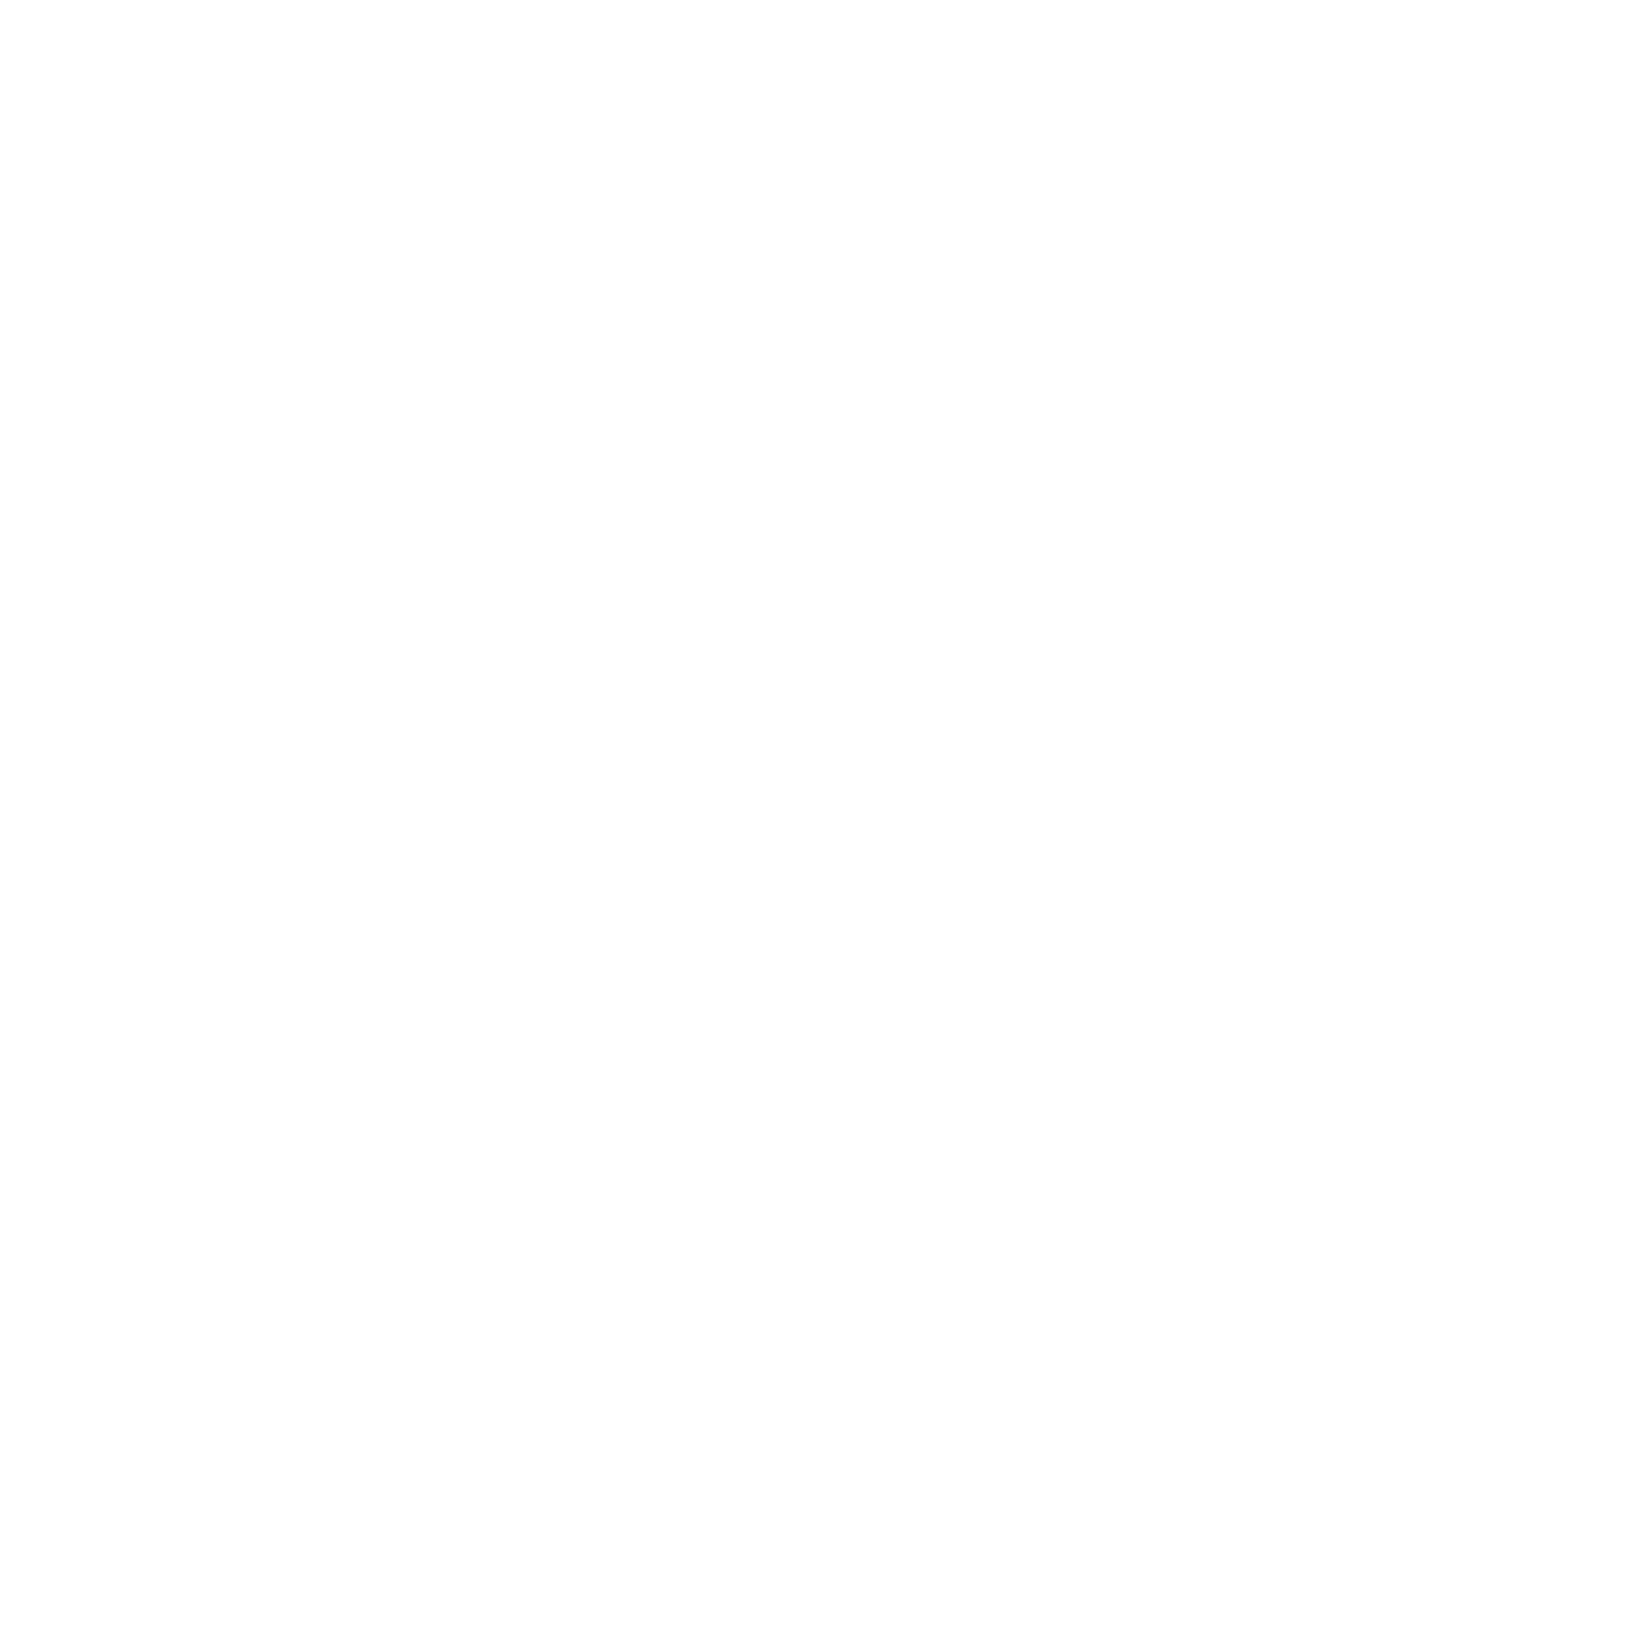

In [229]:
rcParams['figure.figsize'] = (10, 10)
nx.draw(grn, graphviz_layout(grn), with_labels=True)

In [165]:
nx.write_graphml(grn, "pruned_grn.graphml.gz")